Entrainement de modèles de base et d'un modèle CatModel qui les concatène.  

Les définitions communes sont dans **rakuten_common.py**
  * NB_ECHANTILLONS: Nombre d'échantillons utilisés (-1 par défaut => tous)
  * TEST_SIZE: Ratio utilisé pour les tests (0.2 par défaut)
  * VALIDATION_SPLIT: Ratio utilisé pour la validation (0.15 par défaut)
  * RakutenBaseModel: Classe de base des modèles
  * RakutenCatModel: Classe de base pour les modèles utilisant des modèles de base
  * get_X...: Fonctions diverses retournant des données preprocessées, créant un fichier cache si nécessaire

Les fichiers intermédiaires et finaux sont tous créés dans le répertoire **modele_rakuten_out**.

L'exécution d'un modèle se fait ainsi:

        modele().evaluate(NB_ECHANTILLONS)  

Après entrainement et prédiction, un rapport est affiché et le modèle est sauvegardé sur disque.

Le modèle qui utilise des modèles de base déjà exécutés les déclare dans la méthode **config** (voir objs dans CatModel.config()): Les objets de bases suvegardés sur disque sont alors chargés, pour récupérer l'architecture de leurs layers ainsi que leurs poids, afin de construire le modèle concaténant.


In [1]:
from rakuten_common import *

In [2]:
class EmbedRNN(RakutenBaseModel):
    """
    Modèle texte avec un layer Embedding et un layer GRU
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        if not hasattr(self, "std"):
            # Appel pour la création du modèle
            self.maxlen = 600
            self.num_words = 70000
            self.embedding_dim = 200
            self.tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=self.num_words)

    def get_class_weight(self):
        indices = {int(self.fit_labels[i]):i for i in self.fit_labels}
        cw = {i: 1 for i in range(NB_CLASSES)}
        #cw[indices[1280]] = 2
        return cw

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=(self.maxlen,),
                                    name=self.layer_name("input"))
        x = tf.keras.layers.Embedding(self.num_words, self.embedding_dim,
                                      name=self.layer_name("embed"))(inp)
        x = tf.keras.layers.GRU(128, return_sequences=True,
                                name=self.layer_name("gru"))(x)
        x = tf.keras.layers.Dropout(0.3, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.GlobalAveragePooling1D(name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dense(256, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.3, name=self.layer_name("dropout"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        X_train = get_X_text(input_file)[off_start:off_end]
        self.tokenizer.fit_on_texts(X_train)
        self.word2idx = self.tokenizer.word_index
        self.idx2word = self.tokenizer.index_word
        self.vocab_size = self.tokenizer.num_words
        
        X_train = self.tokenizer.texts_to_sequences(X_train)
        X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                                maxlen=self.maxlen,
                                                                padding='post')
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text(input_file)[off_start:off_end]
        X_test = self.tokenizer.texts_to_sequences(X_test)
        X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                               maxlen=self.maxlen,
                                                               padding='post')

        return X_test

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()
        
        return self.compile_and_train_gen(X_train, y_train, X_val, y_val, optimizer='adam',
                                         epochs=50, patience_stop=8, patience_lr=3,
                                          class_weight=[])

++ [20h51mn] EmbedRNN: Evaluation avec 84916 échantillons
++ [20h51mn] EmbedRNN: fit(): Début
Epoch 1/50
1805/1805 [==============================] - 390s 215ms/step - loss: 1.5638 - accuracy: 0.5239 - val_loss: 0.8156 - val_accuracy: 0.7560
Epoch 2/50
1805/1805 [==============================] - 387s 214ms/step - loss: 0.6223 - accuracy: 0.8151 - val_loss: 0.6466 - val_accuracy: 0.8093
Epoch 3/50
1805/1805 [==============================] - 387s 214ms/step - loss: 0.3368 - accuracy: 0.8982 - val_loss: 0.6733 - val_accuracy: 0.8156
Epoch 4/50
1805/1805 [==============================] - 386s 214ms/step - loss: 0.1897 - accuracy: 0.9427 - val_loss: 0.7434 - val_accuracy: 0.8099
Epoch 5/50
1805/1805 [==============================] - 387s 215ms/step - loss: 0.1167 - accuracy: 0.9644 - val_loss: 0.9055 - val_accuracy: 0.8116

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/50
1805/1805 [==============================] - 390s 216ms/step - loss: 0.05

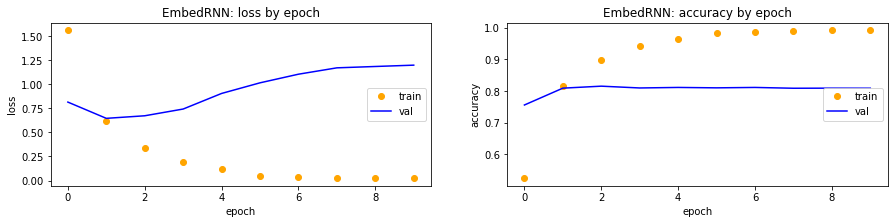

++ [21h56mn] EmbedRNN: fit(): Fin

++ [21h56mn] EmbedRNN: predict(): Début
531/531 [==============================] - 10s 19ms/step
++ [21h56mn] EmbedRNN: predict(): Fin

++ [21h56mn] EmbedRNN: w-f1-score = 0.8074

              precision    recall  f1-score   support

          10       0.51      0.60      0.55       652
        1140       0.71      0.77      0.74       541
        1160       0.90      0.93      0.91       815
        1180       0.76      0.45      0.57       140
        1280       0.74      0.69      0.71       956
        1281       0.52      0.57      0.54       399
        1300       0.96      0.94      0.95      1051
        1301       0.94      0.87      0.90       168
        1302       0.83      0.75      0.79       497
        1320       0.70      0.80      0.75       683
        1560       0.82      0.82      0.82       993
        1920       0.92      0.88      0.90       841
        1940       0.73      0.84      0.78       147
        2060       0.84     

In [39]:
EmbedRNN().evaluate(NB_ECHANTILLONS)

In [3]:
class Multilingu(RakutenBaseModel):
    """
    Utilisation d'un modèle texte pré-entrainé (Multilingual-large) pour obtenir
    des vecteurs d'embedding.
    La fonction get_X_text_embed_multilingual() retourne ces vecteurs. Les plongements
    des phrases sont effectués lors de la première exécution et stocké dans un fichier
    qui est simplement lu par la suite.
    Pour utiliser ce mdèle il faut télécharger 
           https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3
    et l'extraire en tant que tfhub/universal-sentence-encoder-multilingual-large-3
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        if not hasattr(self, "std"):
            # Appel pour la création du modèle
            self.embedding_length = 512 # Défini par le modèle Multilingual/large
            self.std = StandardScaler()

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=(self.embedding_length,),
                                    name=self.layer_name("input"))
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(inp)
        x = tf.keras.layers.Dense(200, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
#        x = tf.keras.layers.Dense(100, activation='relu', name=self.layer_name("dense"))(x)
#        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        X_train = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_train = self.std.fit_transform(X_train)
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_test = self.std.transform(X_test)
        return X_test

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()
        
        return self.compile_and_train_gen(X_train, y_train, X_val, y_val, optimizer='adam',
                                         epochs=50, patience_stop=7, patience_lr=3)


++ [08h13mn] Multilingu: Evaluation avec 84916 échantillons
++ [08h13mn] Multilingu: fit(): Début
Epoch 1/50
1805/1805 [==============================] - 8s 4ms/step - loss: 1.0750 - accuracy: 0.6807 - val_loss: 0.7463 - val_accuracy: 0.7660
Epoch 2/50
1805/1805 [==============================] - 7s 4ms/step - loss: 0.8065 - accuracy: 0.7503 - val_loss: 0.7034 - val_accuracy: 0.7813
Epoch 3/50
1805/1805 [==============================] - 7s 4ms/step - loss: 0.7379 - accuracy: 0.7683 - val_loss: 0.6686 - val_accuracy: 0.7943
Epoch 4/50
1805/1805 [==============================] - 7s 4ms/step - loss: 0.6992 - accuracy: 0.7766 - val_loss: 0.6724 - val_accuracy: 0.7867
Epoch 5/50
1805/1805 [==============================] - 7s 4ms/step - loss: 0.6664 - accuracy: 0.7851 - val_loss: 0.6716 - val_accuracy: 0.7943
Epoch 6/50
1805/1805 [==============================] - 7s 4ms/step - loss: 0.6379 - accuracy: 0.7934 - val_loss: 0.6593 - val_accuracy: 0.7975
Epoch 7/50
1805/1805 [================

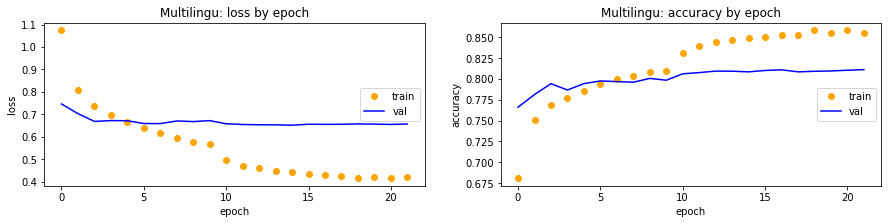

++ [08h16mn] Multilingu: fit(): Fin

++ [08h16mn] Multilingu: predict(): Début
531/531 [==============================] - 1s 875us/step
++ [08h16mn] Multilingu: predict(): Fin

++ [08h16mn] Multilingu: w-f1-score = 0.8014

              precision    recall  f1-score   support

          10       0.58      0.60      0.59       652
        1140       0.73      0.72      0.73       541
        1160       0.91      0.92      0.92       815
        1180       0.65      0.60      0.62       140
        1280       0.61      0.60      0.61       956
        1281       0.65      0.48      0.55       399
        1300       0.82      0.93      0.87      1051
        1301       0.95      0.82      0.88       168
        1302       0.72      0.76      0.74       497
        1320       0.75      0.73      0.74       683
        1560       0.77      0.76      0.77       993
        1920       0.88      0.88      0.88       841
        1940       0.90      0.91      0.91       147
        2060       0

In [9]:
Multilingu().evaluate(NB_ECHANTILLONS)

In [4]:
class NPDataset(tf.keras.utils.Sequence):
    """
    Générateur qui extrait les données (de type tableau numpy)
    à partir d'un path de fichier (passer par un fichier évite
    le risque de OOM avec les grosses matrices denses one hot)
    """
    def __init__(self, batch_size,
                 X, y=None, shuffle=False, random_state=1968):
        nb = len(X)
        self.y = y
        self.batch_size = batch_size
        self.batch_number = int(nb / batch_size)
        self.batch_indexes = range(self.batch_number)
        self.prefix = re.match(r'^(.*)_\d+\.npy$', X[0]).group(1)
        if shuffle:
            self.random_state = random_state
            self.batch_indexes = sklearn.utils.shuffle(self.batch_indexes,
                                                       random_state=random_state)
        self.shuffle = shuffle

    def __len__(self):
        """ Retourne le nombre de batchs """
        return self.batch_number

    def __getitem__(self, index):
        index = self.batch_indexes[index]
        X = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            f = f"{self.prefix}_{i}.npy"
            with open(f, 'rb') as fd:
                x = np.load(fd)
                X.append(x)
        X = np.array(X)
        if self.y is None:
            return X
        else:
            y = self.y[index*self.batch_size : (index+1)*self.batch_size]
            return X, y

    def on_epoch_end(self):
        """ Changements effectués à chaque fin d'époque """
        if self.shuffle:
            self.batch_indexes = sklearn.utils.shuffle(self.batch_indexes,
                                                       random_state=self.random_state)
        

class TextOneHot(RakutenBaseModel):
    """
    Mini modèle NN exécuté après un préprocessing des données effectué
    avec un pipe sklearn TfidfVectorizer | SelectFromModel(LinearSVC)
    
    Il faut télécharger la base de donnée Spacy pour le français:
                     python -m spacy download fr_core_news_sm
    Les textes sont tokenizés et lemattisés en utilisant Spacy, la fonction
    get_X_text_spacy_lemma() retourne ces textes préprocessés en les lisant
    dans un fichier qui est construit lors de la première utilisation.
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        if not hasattr(self, "select"):
            # Appel pour la création du modèle
            self.privatedir = os.path.join(OUTDIR, self.name)
            self.maxfeatures = 50000 # Nombre de features selectionnées par SVC
            self.select = make_pipeline(
                TfidfVectorizer(analyzer='word',
                  #strip_accents='ascii',
                  #stop_words=french_stop_words, 
                  #    tokenizer=tokenize_spacy, # les données sont déjà tokenizées
                  preprocessor=' '.join,
                  lowercase=False,
                  stop_words=None,
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
 #                 max_features=30000,  moins rentable que celui de SelectFromModel 
                  ),
                  SelectFromModel(LinearSVC(penalty="l2", dual=True, C=0.8,
                                            tol=1e-5, max_iter=4000),
                                  max_features=self.maxfeatures))

    def __flush_data_to_file(self, data, tag, off_start, off_end, input_file=None):
        if not os.path.isdir(self.privatedir):
            os.makedirs(self.privatedir)
        filelist = []
        for i in range(data.shape[0]):
            f = os.path.join(self.privatedir,
                             f"{tag}_{off_start}_{off_end}_{i}.npy")
            with open(f, 'wb') as fd:
                datum = data[i].toarray()[0]
                np.save(fd, datum)
            filelist.append(f)
        return filelist
    
    def data_from_file(self, filepath):
        """
        Méthode pour lire une donnée preprocessée à partir d'un fichier
        et la retourner
        """
        with open(filepath, 'rb') as fd:
            datum = np.load(fd)
        return datum

#    def get_class_weight(self):
#        indices = {int(self.fit_labels[i]):i for i in self.fit_labels}
#        cw = {i: 1 for i in range(NB_CLASSES)}
#        cw[indices[10]] = 2
#        return cw

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=self.input_shape, name=self.layer_name("input"))
        x = inp
        x = tf.keras.layers.Dense(90, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        y_train = get_y()[off_start:off_end]
#            X_train = get_X_text(input_file)[off_start:off_end]
        X_train = get_X_text_spacy_lemma(input_file)[off_start:off_end]
        X_train = self.select.fit_transform(X_train, y_train)
        self.input_shape = X_train.shape[1:]
        self.prt(f"Nombre de mots retenus = {self.input_shape[0]}")
        return self.__flush_data_to_file(X_train, "train", off_start, off_end)

    def preprocess_X_test(self, off_start, off_end, input_file=None):
#        X_test = get_X_text(input_file)[off_start:off_end]
        X_test = get_X_text_spacy_lemma(input_file)[off_start:off_end]
        X_test = self.select.transform(X_test)
        return self.__flush_data_to_file(X_test, "test", off_start, off_end)

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)
        trainds = NPDataset(self.batch_size, X_train, y_train, shuffle=True)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)
        valds = NPDataset(self.batch_size, X_val, y_val, shuffle=True)

        self.model = self.get_model()

        return self.compile_and_train_dataset(trainds, valds,
                                              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                                              epochs=20,
                                              patience_stop=6, patience_lr=3)

    def predict(self, off_start, off_end, input_file=None):
        X_test = self.preprocess_X_test(off_start, off_end, input_file)
        testds = NPDataset(1, X_test, shuffle=False)
        return self.model_predict(testds)

++ [23h30mn] TextOneHot: Evaluation avec 84916 échantillons
++ [23h31mn] TextOneHot: Nombre de mots retenus = 50000


C:\Users\Eric\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


++ [23h52mn] TextOneHot: fit(): Début
Epoch 1/20
1804/1804 [==============================] - 2914s 2s/step - loss: 1.6359 - accuracy: 0.6350 - val_loss: 0.8041 - val_accuracy: 0.8052
Epoch 2/20
1804/1804 [==============================] - 2320s 1s/step - loss: 0.6835 - accuracy: 0.8431 - val_loss: 0.5848 - val_accuracy: 0.8372
Epoch 3/20
1804/1804 [==============================] - 2223s 1s/step - loss: 0.3924 - accuracy: 0.9109 - val_loss: 0.5246 - val_accuracy: 0.8464
Epoch 4/20
1804/1804 [==============================] - 2321s 1s/step - loss: 0.2419 - accuracy: 0.9467 - val_loss: 0.5138 - val_accuracy: 0.8522
Epoch 5/20
1804/1804 [==============================] - 2237s 1s/step - loss: 0.1607 - accuracy: 0.9650 - val_loss: 0.5248 - val_accuracy: 0.8490
Epoch 6/20
1804/1804 [==============================] - 2293s 1s/step - loss: 0.1099 - accuracy: 0.9764 - val_loss: 0.5437 - val_accuracy: 0.8513
Epoch 7/20
1804/1804 [==============================] - 2551s 1s/step - loss: 0.0787 -

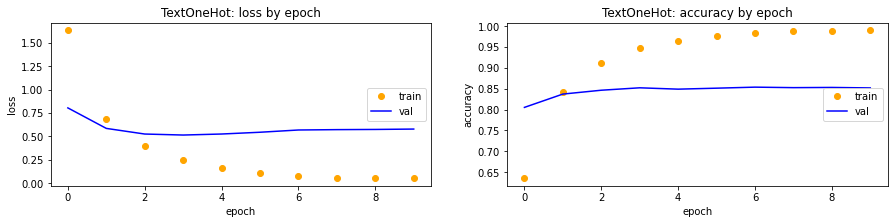

++ [06h32mn] TextOneHot: fit(): Fin

++ [06h37mn] TextOneHot: predict(): Début
16984/16984 [==============================] - 224s 12ms/step
++ [06h41mn] TextOneHot: predict(): Fin

++ [06h41mn] TextOneHot: w-f1-score = 0.8456

              precision    recall  f1-score   support

          10       0.56      0.65      0.60       652
        1140       0.80      0.81      0.80       541
        1160       0.95      0.95      0.95       815
        1180       0.83      0.64      0.73       140
        1280       0.72      0.75      0.73       956
        1281       0.66      0.62      0.64       399
        1300       0.95      0.95      0.95      1051
        1301       0.99      0.90      0.94       168
        1302       0.87      0.83      0.85       497
        1320       0.89      0.85      0.87       683
        1560       0.82      0.85      0.84       993
        1920       0.92      0.93      0.92       841
        1940       0.91      0.94      0.92       147
        2060   

In [5]:
TextOneHot().evaluate(NB_ECHANTILLONS)

In [5]:
class EffNetB1(RakutenBaseModel):
    """
    Modèle de transfert learning d'images avec EfficientNet et l'utilisation
    d'un générateur d'images augmentées.
    https://www.dlology.com/blog/transfer-learning-with-efficientnet/
    Le modèle B5 a le format d'image (456x456) le plus proche de celles à
    classer (500x500), il est plus performant que B1 (~0.87 versus ~0.85)
    mais beaucoup plus coûteux en temps d'éxecution.
    """

    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        self.input_shape = (240, 240, 3) # Dépend du numéro x (EfficientNetBx)
        self.preprocessing_function = None # Inclus dans le modèle
        self.basetrainable = 8
        self.epochs_freezed = 10
        self.epochs_unfreezed = 20
        self.batch_size = 32

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]
    
    def data_from_file(self, filepath):
        """
        Méthode pour lire une image à partir d'un fichier et la retourner
        au bon format (adapté aux entrées du modèle modèle)
        """
        img = cv2.imread(filepath)
        img = cv2.resize(img, (240, 240), interpolation=cv2.INTER_CUBIC)
        return img

    def get_model_body(self):
        self.layer_index = 0
        self.basemodel = tf.keras.applications.EfficientNetB1(
                                input_shape = self.input_shape,
                                include_top = False,
                                # drop_connect_rate=0.4,
                                weights = 'imagenet')
        inp = Input(shape=self.input_shape, name="input_" + self.name)
        x = self.basemodel(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True,axis=1, name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(512, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True, axis=1, name=self.layer_name("batchnorm"))(x)
        return inp, x

    def __get_train_dataset(self, X_imagepaths, y_train):
        df = pd.DataFrame({"imgpath": X_imagepaths, "class": y_train})
        datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                                    validation_split = VALIDATION_SPLIT,
                                    preprocessing_function = self.preprocessing_function,
                                    rotation_range = 10,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.1,
                                    brightness_range=[0.9, 1.1],
                                    horizontal_flip = True
                                    )
        traingen = datagenerator.flow_from_dataframe(subset = 'training', dataframe=df,
                                                     x_col="imgpath", y_col="class",
                                                     class_mode="sparse",
                                                     target_size=(self.input_shape[0], self.input_shape[1]),
                                                     batch_size=self.batch_size)
        valgen = datagenerator.flow_from_dataframe(subset='validation',
                                                   dataframe=df, x_col="imgpath", y_col="class",
                                                   class_mode="sparse",
                                                   target_size=(self.input_shape[0], self.input_shape[1]),
                                                   batch_size=self.batch_size)
        return traingen, valgen

    def __get_test_dataset(self, X_imagepaths):
        df = pd.DataFrame({"imgpath": X_imagepaths,
                           "class": [0 for _ in range(len(X_imagepaths))]})
        testgen = tf.keras.preprocessing.image.ImageDataGenerator( 
                        preprocessing_function = self.preprocessing_function).flow_from_dataframe(
                        dataframe=df, x_col="imgpath", y_col="class",
                        class_mode=None, target_size=(self.input_shape[0], self.input_shape[1]),
                        batch_size=1,
                        shuffle = False)
        return testgen

    def fit(self, off_start, off_val, off_end, input_file=None):

        self.prt(f"Création des générateurs d'images")
        X_imgpaths = get_X_image_path(input_file)[off_start:off_end]
        y_train = get_y()[off_start:off_end]
        traingen, valgen = self.__get_train_dataset(X_imgpaths, y_train)
        self.fit_labels = dict((v,k) for k,v in (traingen.class_indices).items())

        self.model = self.get_model()
        
        self.prt(f"Congélation des layers du modèle de base et entrainement")
        for layer in self.basemodel.layers:
            layer.trainable = False
        history = self.compile_and_train_dataset(traingen, valgen,
                                         optimizer=tf.keras.optimizers.Adam(lr=0.01),
                                         epochs=self.epochs_freezed)
        if self.basetrainable > 0:
            self.prt(f"Décongélation des {self.basetrainable} derniers layers et entrainement")
            for layer in self.basemodel.layers[-self.basetrainable:]:
                if not isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = True
            self.compile_and_train_dataset(traingen, valgen,
                                   optimizer=tf.keras.optimizers.Adam(lr=0.00008),
                                    patience_lr=3,
                                   epochs=self.epochs_unfreezed)
        self.prt("Entrainement terminé")
        return history

    def predict(self, off_start, off_end, input_file=None):
        X_test = self.preprocess_X_test(off_start, off_end, input_file)
        testgen = self.__get_test_dataset(X_test)
        return self.model_predict(testgen)


++ [10h20mn] EffNetB1: Evaluation avec 84916 échantillons
++ [10h20mn] EffNetB1: Création des générateurs d'images
Found 57743 validated image filenames belonging to 27 classes.
Found 10189 validated image filenames belonging to 27 classes.
++ [10h21mn] EffNetB1: Congélation des layers du modèle de base et entrainement
++ [10h21mn] EffNetB1: fit(): Début


C:\Users\Eric\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1805/1805 [==============================] - 1935s 1s/step - loss: 1.8378 - accuracy: 0.4703 - val_loss: 1.5670 - val_accuracy: 0.5361
Epoch 2/10
1805/1805 [==============================] - 1261s 698ms/step - loss: 1.6150 - accuracy: 0.5194 - val_loss: 1.5159 - val_accuracy: 0.5479
Epoch 3/10
1805/1805 [==============================] - 1242s 688ms/step - loss: 1.5526 - accuracy: 0.5371 - val_loss: 1.4811 - val_accuracy: 0.5604
Epoch 4/10
1805/1805 [==============================] - 1260s 698ms/step - loss: 1.5127 - accuracy: 0.5505 - val_loss: 1.4588 - val_accuracy: 0.5722
Epoch 5/10
1805/1805 [==============================] - 1278s 708ms/step - loss: 1.4683 - accuracy: 0.5599 - val_loss: 1.3819 - val_accuracy: 0.5880
Epoch 6/10
1805/1805 [==============================] - 1258s 697ms/step - loss: 1.4366 - accuracy: 0.5708 - val_loss: 1.3878 - val_accuracy: 0.5893
Epoch 7/10
1805/1805 [==============================] - 1203s 666ms/step - loss: 1.3978 - accuracy: 0.5805 - 

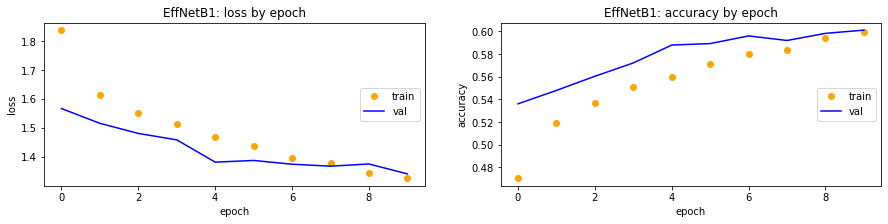

++ [14h00mn] EffNetB1: fit(): Fin

++ [14h00mn] EffNetB1: Décongélation des 8 derniers layers et entrainement
++ [14h00mn] EffNetB1: fit(): Début
Epoch 1/15
1805/1805 [==============================] - 1307s 719ms/step - loss: 1.2001 - accuracy: 0.6323 - val_loss: 1.2564 - val_accuracy: 0.6248
Epoch 2/15
1805/1805 [==============================] - 1238s 686ms/step - loss: 1.1391 - accuracy: 0.6492 - val_loss: 1.2362 - val_accuracy: 0.6283
Epoch 3/15
1805/1805 [==============================] - 1280s 709ms/step - loss: 1.0988 - accuracy: 0.6609 - val_loss: 1.2291 - val_accuracy: 0.6345
Epoch 4/15
1805/1805 [==============================] - 1302s 721ms/step - loss: 1.0618 - accuracy: 0.6698 - val_loss: 1.2194 - val_accuracy: 0.6368
Epoch 5/15
1805/1805 [==============================] - 1324s 733ms/step - loss: 1.0389 - accuracy: 0.6775 - val_loss: 1.2174 - val_accuracy: 0.6396
Epoch 6/15
1805/1805 [==============================] - 1323s 733ms/step - loss: 1.0005 - accuracy: 0.6868 - 

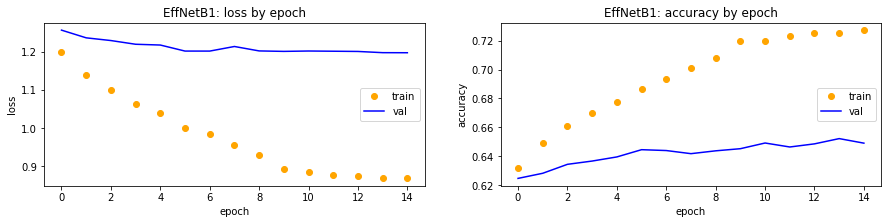

++ [19h11mn] EffNetB1: fit(): Fin

++ [19h11mn] EffNetB1: Entrainement terminé
Found 16984 validated image filenames.
++ [19h11mn] EffNetB1: predict(): Début
16984/16984 [==============================] - 541s 32ms/step
++ [19h20mn] EffNetB1: predict(): Fin

++ [19h20mn] EffNetB1: w-f1-score = 0.6473

              precision    recall  f1-score   support

          10       0.53      0.63      0.57       652
        1140       0.65      0.67      0.66       541
        1160       0.89      0.93      0.91       815
        1180       0.45      0.36      0.40       140
        1280       0.47      0.45      0.46       956
        1281       0.42      0.23      0.30       399
        1300       0.70      0.79      0.74      1051
        1301       0.69      0.69      0.69       168
        1302       0.56      0.47      0.51       497
        1320       0.54      0.49      0.52       683
        1560       0.62      0.57      0.59       993
        1920       0.76      0.83      0.79     

C:\Users\Eric\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


++ [19h20mn] EffNetB1: Modèle sauvegardé dans modele_rakuten_out\EffNetB1_84916_model.hdf5
Pas de sauvegarde de  basemodel
++ [19h20mn] EffNetB1: Objet complet sauvegardé dans modele_rakuten_out\EffNetB1_84916_object.pkl


In [34]:
#https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
EffNetB1().evaluate(NB_ECHANTILLONS)

In [6]:
class CatModel(RakutenCatModel):
    """
    Modèle qui concatene plusieurs modèles de base. ceux ci sont
    listés et instanciées dans self.objs. le paramètre nb permet
    de corréler les fichiers créés par les modèles de base et le
    modèle de concaténation, ils ont tous le même nb (en pratique
    il s'agit du nombre d'échantillons utilisés).
    
    Le modèle utilise un layer Keras concatenate après appel des
    méthodes get_model_body() de chaque modèle de base afin de
    récupérer l'architecture des layers de ces modèles.
    
         +----------+  +----------+  +----------+
         | modèle A |  | modèle B |  | modèle C |
         +-----+----+  +-----+----+  +-----+----+
               |             |             |
               +-------+     |    +--------+
                       |     |    |
                    +--v-----v----v--+
                    |   concatenate  |
                    +--------+-------+
                             |
                    +--------v-------+
                    |  top layerss   |
                    +----------------+
                    
    Une fois le modèle compilé, les poids des layers de bases sont
    initialisés avec ceux des objets modèles de base, grace à la
    méthode copy_submodules_weights().
    """
    def config(self, nb):
        """ Déclaration des modèles de base utilisés """
        if not hasattr(self, "objs") and nb is not None:
            self.objs = [
                         EmbedRNN(nb),
                         TextOneHot(nb),
                         Multilingu(nb),
                         EffNetB1(nb)
                        ]

    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)

        self.config(nb)
        
    def fit(self, off_start, off_val, off_end, input_file=None):
        """
        Entrainement du modèle sur l'intervalle des données spécifié par
        off_start et off_end (offsets dans les fichiers de data).
        """

        self.prt(f'Chargements des modèles référencés "{self.nb}"')
        self.config(self.nb)

        # Générateurs qui alimenteront fit() avec les données train & val
        traingen, valgen = self.create_train_generators(off_start, off_val, off_end, input_file)
        
        self.prt(f"Création du modèle")
        # Récupèration des inputs et des outputs de chaque modèle de base
        # pour construire le modèle concatenate
        inputtensors, outputtensors = [], []
        for obj in self.objs:
            inp, outp = obj.get_model_body()
            inputtensors.append(inp)
            outputtensors.append(outp)
        
        self.layer_index = 0 # compteur utilisé dans get_model_body()
        
        tensors = outputtensors
#        outputtensors = []
#        for x in tensors:
#            x = BatchNormalization(name=self.layer_name("batchnorm"))(x)
#            x = Dense(128, activation='relu', name=self.layer_name("dense"))(x)
#            outputtensors.append(x)

        x = concatenate(outputtensors, axis=-1, name = self.layer_name("concatenate"))
#        x = Dense(64, activation='relu', name=self.layer_name("dense"))(x)
#        x = Dropout(0.2, name=self.layer_name("dropout"))(x)
#        x = BatchNormalization(name=self.layer_name("batchnorm"))(x)
        x = Dense(NB_CLASSES, activation='softmax', name=self.layer_name("dense"))(x)
        self.model = Model(inputtensors, x, name=self.name)

        #print(self.model.summary())

        print(f"  * Layers non entrainables:")
        for layer in self.model.layers:
            if layer.name.find(self.name) < 0:
                layer.trainable = False
                print(f"      - {layer.name}")
#        for layer in self.model.layers:
#            if 0 <= layer.name.find('efficient'):
#                layer.trainable = False
#                print(f"      - {layer.name}")
        print(f"  * Layers entrainables:")
        for layer in self.model.layers:
            if layer.trainable:
                print(f"      - {layer.name}")

        self.model.compile(optimizer= tf.keras.optimizers.Adam(lr=0.001),
                           loss='sparse_categorical_crossentropy',
                           metrics = ['accuracy'])

        # Initialisation des poids
        self.copy_submodels_weights()

        self.prt("fit(): Début")    
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                             restore_best_weights=True, verbose=1),
                     tf.keras.callbacks.ModelCheckpoint(filepath=self.fbestweights,
                                             save_weights_only=True, save_best_only=True,
                                              monitor='val_loss', mode='min'),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1,
                                                          verbose=1)]
        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        history = self.model.fit(traingen,
                                 epochs=15,
                                 validation_data = valgen,
                                 callbacks=callbacks)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        self.prt("fit(): Fin")
        plot_history(f"{self.name}", history)

        print(f"Décongélation des layers suivants:")
        for layer in self.model.layers:
            if not layer.trainable and layer.name.find("efficient") < 0:
                print(f"      - {layer.name}")

        self.model.compile(optimizer= tf.keras.optimizers.Adam(lr=0.0001),
                           loss='sparse_categorical_crossentropy',
                           metrics = ['accuracy'])


        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        history = self.model.fit(traingen,
                                 epochs=15,
                                 validation_data = valgen,
                                 callbacks=callbacks)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        self.prt("fit(): Fin")
        plot_history(f"{self.name}", history)

        return history

++ [09h00mn] CatModel: Evaluation avec 84916 échantillons
++ [09h00mn] CatModel: Chargements des modèles référencés "84916"
Chargement de l'objet (modele_rakuten_out\EmbedRNN_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\EmbedRNN_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\TextOneHot_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\TextOneHot_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\Multilingu_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\Multilingu_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\EffNetB1_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\EffNetB1_84916_model.hdf5)
++ [09h00mn] CatModel: Preprocessing des 67932 données d'entrainement
++ [09h01mn] TextOneHot: Nombre de mots retenus = 50000
++ [09h24mn] CatModel: Instantiation des générateurs d'entrainement
Nettoyage de modele_rakuten_out\CatDataset_train_57742
Création de 1804 fichiers de batch dans modele_rakuten_out\CatDataset_t

  0%|          | 0/1804 [00:00<?, ?it/s]

* modèle TextOneHot


  0%|          | 3/1804 [00:00<01:02, 29.03it/s]

* modèle Multilingu


  0%|          | 0/1804 [00:00<?, ?it/s]

* modèle EffNetB1


100%|██████████| 1804/1804 [33:44<00:00,  1.12s/it] 


Nettoyage de modele_rakuten_out\CatDataset_val_10190


  8%|▊         | 24/318 [00:00<00:01, 237.82it/s]

Création de 318 fichiers de batch dans modele_rakuten_out\CatDataset_val_10190
* modèle EmbedRNN


  0%|          | 0/318 [00:00<?, ?it/s]

* modèle TextOneHot


  1%|          | 3/318 [00:00<00:13, 23.25it/s]

* modèle Multilingu


  0%|          | 0/318 [00:00<?, ?it/s]

* modèle EffNetB1


100%|██████████| 318/318 [03:55<00:00,  1.35it/s]


++ [11h03mn] CatModel: Création du modèle
  * Layers non entrainables:
      - input_EffNetB1
      - input_1_EmbedRNN
      - efficientnetb1
      - embed_2_EmbedRNN
      - global_average_pooling2d
      - gru_3_EmbedRNN
      - dense_1_EffNetB1
      - dropout_4_EmbedRNN
      - input_1_TextOneHot
      - input_1_Multilingu
      - batchnorm_2_EffNetB1
      - batchnorm_5_EmbedRNN
      - dense_2_TextOneHot
      - batchnorm_2_Multilingu
      - dropout_3_EffNetB1
      - dense_6_EmbedRNN
      - dropout_3_TextOneHot
      - dense_3_Multilingu
      - dense_4_EffNetB1
      - dropout_7_EmbedRNN
      - batchnorm_4_TextOneHot
      - dropout_4_Multilingu
      - batchnorm_5_EffNetB1
  * Layers entrainables:
      - concatenate_1_CatModel
      - dense_2_CatModel
  * Init des layers avec les poids des modèles de base:
      - embed_2_EmbedRNN
      - gru_3_EmbedRNN
      - dense_6_EmbedRNN
      - dense_2_TextOneHot


C:\Users\Eric\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


      - batchnorm_4_TextOneHot
      - batchnorm_2_Multilingu
      - dense_3_Multilingu
      - efficientnetb1
      - dense_1_EffNetB1
      - batchnorm_2_EffNetB1
      - dense_4_EffNetB1
      - batchnorm_5_EffNetB1
++ [11h03mn] CatModel: fit(): Début
Epoch 1/15
1804/1804 [==============================] - 607s 317ms/step - loss: 0.1943 - accuracy: 0.9453 - val_loss: 0.4261 - val_accuracy: 0.8788
Epoch 2/15
1804/1804 [==============================] - 559s 310ms/step - loss: 0.0786 - accuracy: 0.9750 - val_loss: 0.4367 - val_accuracy: 0.8822
Epoch 3/15
1804/1804 [==============================] - 558s 309ms/step - loss: 0.0681 - accuracy: 0.9779 - val_loss: 0.4555 - val_accuracy: 0.8837
Epoch 4/15
1804/1804 [==============================] - 558s 309ms/step - loss: 0.0645 - accuracy: 0.9784 - val_loss: 0.4608 - val_accuracy: 0.8856
Restoring model weights from the end of the best epoch.

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 00004: e

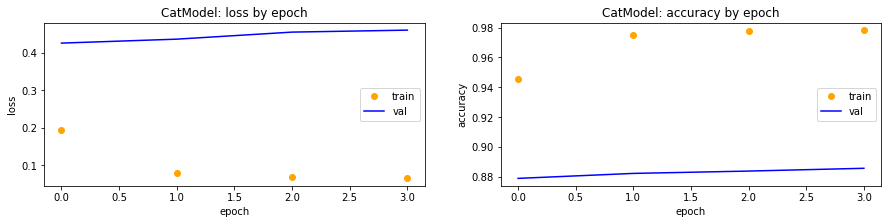

Décongélation des layers suivants:
      - input_EffNetB1
      - input_1_EmbedRNN
      - embed_2_EmbedRNN
      - global_average_pooling2d
      - gru_3_EmbedRNN
      - dense_1_EffNetB1
      - dropout_4_EmbedRNN
      - input_1_TextOneHot
      - input_1_Multilingu
      - batchnorm_2_EffNetB1
      - batchnorm_5_EmbedRNN
      - dense_2_TextOneHot
      - batchnorm_2_Multilingu
      - dropout_3_EffNetB1
      - dense_6_EmbedRNN
      - dropout_3_TextOneHot
      - dense_3_Multilingu
      - dense_4_EffNetB1
      - dropout_7_EmbedRNN
      - batchnorm_4_TextOneHot
      - dropout_4_Multilingu
      - batchnorm_5_EffNetB1
Epoch 1/15
1804/1804 [==============================] - 571s 311ms/step - loss: 0.0804 - accuracy: 0.9753 - val_loss: 0.4153 - val_accuracy: 0.8811
Epoch 2/15
1804/1804 [==============================] - 559s 310ms/step - loss: 0.0767 - accuracy: 0.9761 - val_loss: 0.4134 - val_accuracy: 0.8821
Epoch 3/15
1804/1804 [==============================] - 560s 311ms/st

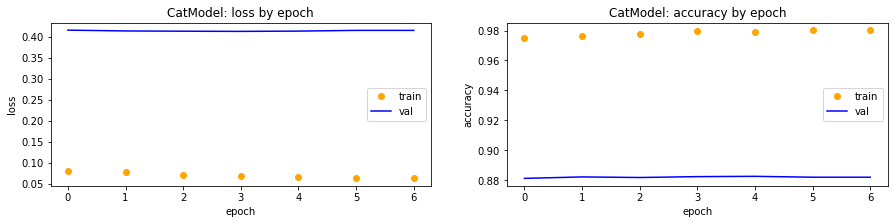

++ [12h47mn] CatModel: Prédiction pour 16984 échantillons
++ [12h47mn] CatModel: Preprocessing des données de test
++ [12h53mn] CatModel: Instantiation du générateur de test
Nettoyage de modele_rakuten_out\CatDataset_test_16984


  2%|▏         | 286/16984 [00:00<00:11, 1484.55it/s]

Création de 16984 fichiers de batch dans modele_rakuten_out\CatDataset_test_16984
* modèle EmbedRNN


  0%|          | 0/16984 [00:00<?, ?it/s]

* modèle TextOneHot


  0%|          | 3/16984 [00:00<10:19, 27.41it/s]

* modèle Multilingu


100%|██████████| 16984/16984 [06:15<00:00, 45.18it/s] 


* modèle EffNetB1


100%|██████████| 16984/16984 [24:11<00:00, 11.70it/s] 


++ [13h46mn] CatModel: predict(): Début
16984/16984 [==============================] - 791s 46ms/step
++ [13h59mn] CatModel: predict(): Fin

++ [13h59mn] CatModel: w-f1-score = 0.8778

              precision    recall  f1-score   support

          10       0.70      0.74      0.72       652
        1140       0.82      0.87      0.84       541
        1160       0.98      0.98      0.98       815
        1180       0.77      0.66      0.71       140
        1280       0.77      0.79      0.78       956
        1281       0.70      0.65      0.67       399
        1300       0.97      0.97      0.97      1051
        1301       0.98      0.90      0.94       168
        1302       0.87      0.86      0.86       497
        1320       0.88      0.85      0.86       683
        1560       0.86      0.86      0.86       993
        1920       0.92      0.93      0.92       841
        1940       0.96      0.95      0.95       147
        2060       0.84      0.83      0.83      1031
    

C:\Users\Eric\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


++ [13h59mn] CatModel: Modèle sauvegardé dans modele_rakuten_out\CatModel_84916_model.hdf5
Pas de sauvegarde de  objs
++ [13h59mn] CatModel: Objet complet sauvegardé dans modele_rakuten_out\CatModel_84916_object.pkl


In [7]:
CatModel().evaluate(NB_ECHANTILLONS)

Classes les plus mal prédites:


,1280,2060,10,2403,1281,1560,40,2582,1320,2280,2705,1140,1302,2522,1920,2585,2462,1180,50,1300
Erreurs,197,179,169,146,139,137,127,118,105,98,77,73,70,64,59,52,47,47,34,30


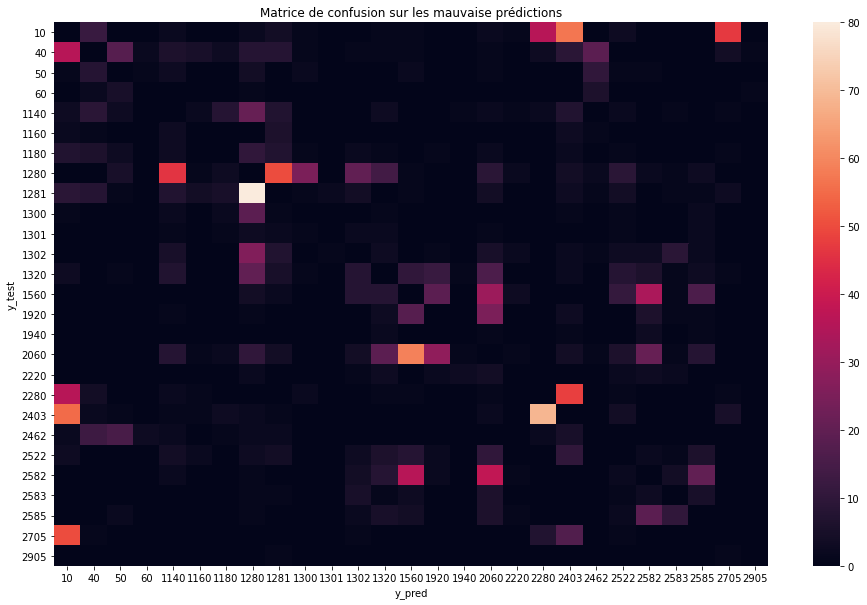

In [8]:
# Analyse des mauvaises prédictions à partir du fichier généré
# ne contenant que les mauvaises prédictions
badf = "modele_rakuten_out\CatModel_84916_bad_predictions.csv"
df = pd.read_csv(badf)

print("Classes les plus mal prédites:")
vc = df.y_test.value_counts()
display(pd.DataFrame(vc[:20]).transpose().rename(index = {'y_test': 'Erreurs'}))

plt.figure(figsize=(16,10))
sns.heatmap(pd.crosstab(df.y_test, df.y_pred))
plt.title("Matrice de confusion sur les mauvaise prédictions")
plt.show()

In [ ]:
# Sauvegarde des modèles et création du fichier csv des
# prédictions sur le fichier officiel de test
CatModel(NB_ECHANTILLONS).deliver()